In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# -------------------------
# Device Configuration
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------
# Data Loaders
# -------------------------
train_dir = r"D:\Rice-Disease-Simulation\data\train"
val_dir = r"D:\Rice-Disease-Simulation\data\validation"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# -------------------------
# VGG-16 Model (Pretrained)
# -------------------------
model = models.vgg16(pretrained=True)

# Freeze early layers (optional)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for rice disease classification
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# -------------------------
# Loss and Optimizer
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -------------------------
# Training Loop
# -------------------------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 39.4803, Train Accuracy: 0.7790
Validation Accuracy: 0.9072
Epoch [2/10], Loss: 10.6369, Train Accuracy: 0.9448
Validation Accuracy: 0.9318
Epoch [3/10], Loss: 5.1446, Train Accuracy: 0.9762
Validation Accuracy: 0.9375
Epoch [4/10], Loss: 2.4965, Train Accuracy: 0.9871
Validation Accuracy: 0.9413
Epoch [5/10], Loss: 2.3854, Train Accuracy: 0.9881
Validation Accuracy: 0.9432
Epoch [6/10], Loss: 1.6173, Train Accuracy: 0.9938
Validation Accuracy: 0.9356
Epoch [7/10], Loss: 0.6646, Train Accuracy: 0.9967
Validation Accuracy: 0.9470
Epoch [8/10], Loss: 0.4618, Train Accuracy: 0.9990
Validation Accuracy: 0.9470
Epoch [9/10], Loss: 0.3676, Train Accuracy: 0.9981
Validation Accuracy: 0.9508
Epoch [10/10], Loss: 0.3522, Train Accuracy: 0.9986
Validation Accuracy: 0.9451


Validation Accuracy: 0.9451


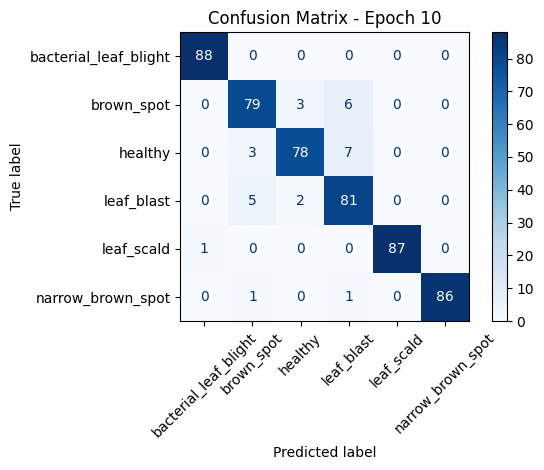

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Validation
model.eval()
val_correct, val_total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc = val_correct / val_total
print(f"Validation Accuracy: {val_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.tight_layout()
plt.show()

In [3]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      1.00      0.99        88
           brown_spot       0.90      0.90      0.90        88
              healthy       0.94      0.89      0.91        88
           leaf_blast       0.85      0.92      0.89        88
           leaf_scald       1.00      0.99      0.99        88
    narrow_brown_spot       1.00      0.98      0.99        88

             accuracy                           0.95       528
            macro avg       0.95      0.95      0.95       528
         weighted avg       0.95      0.95      0.95       528



In [4]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [5]:
target_layer = model.features[-1]  # or model.features[18] usually
cam_extractor = GradCAM(model, target_layer=target_layer)

In [6]:
# Helper to unnormalize a tensor image
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

# Create denormalizer instance using ImageNet stats (used in your transform)
denormalize = Denormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

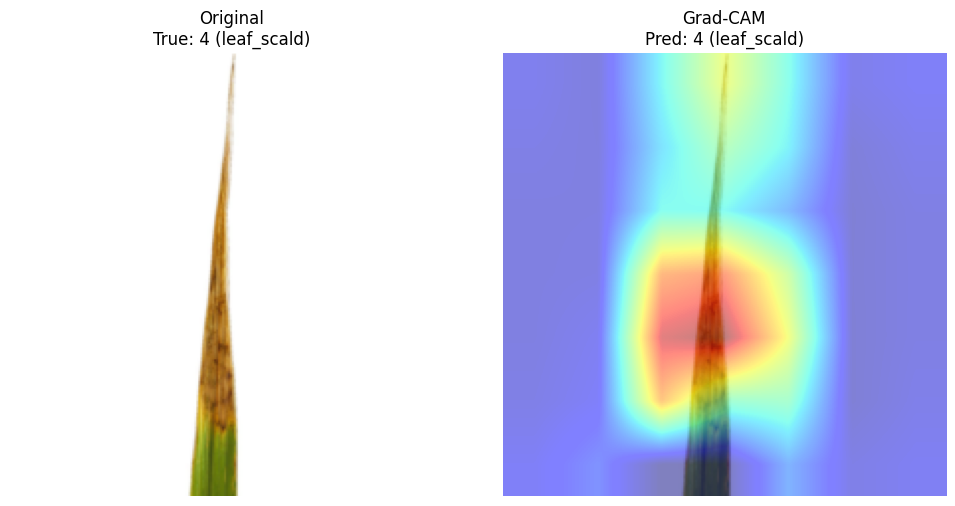

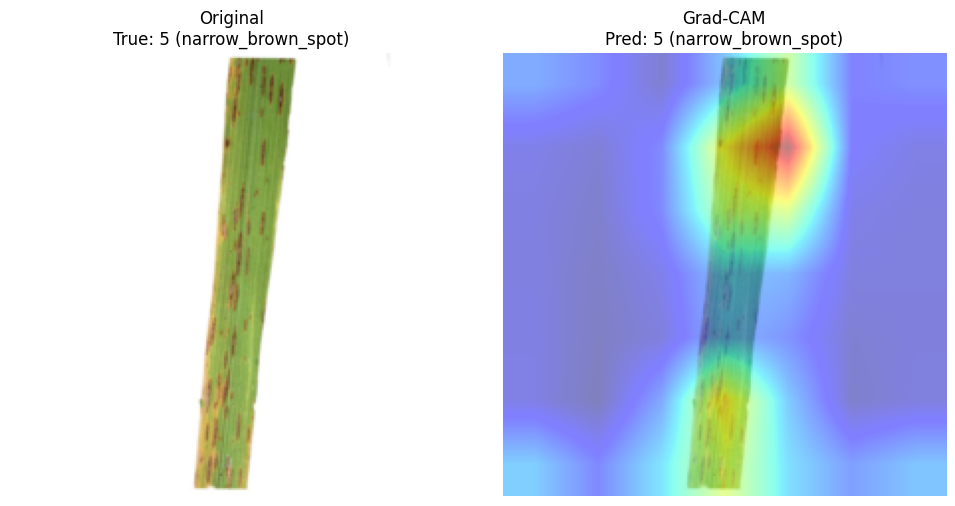

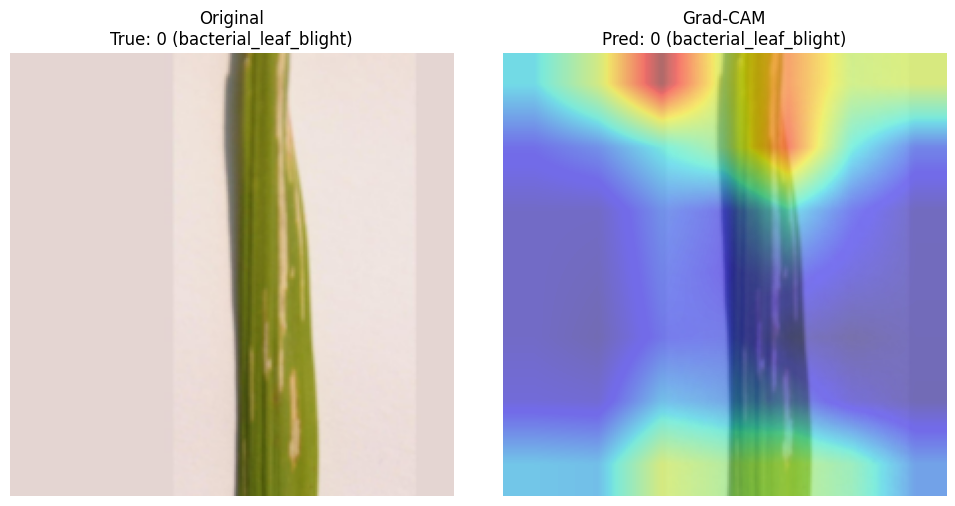

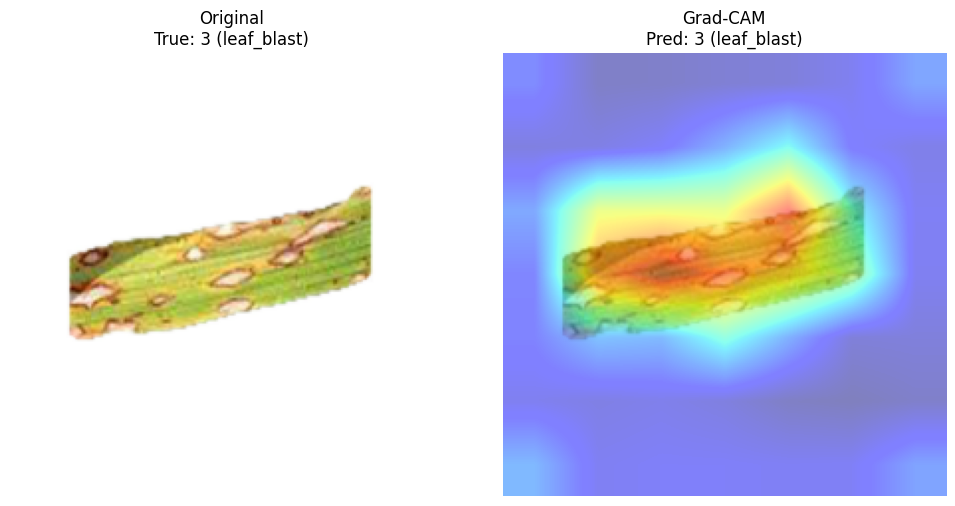

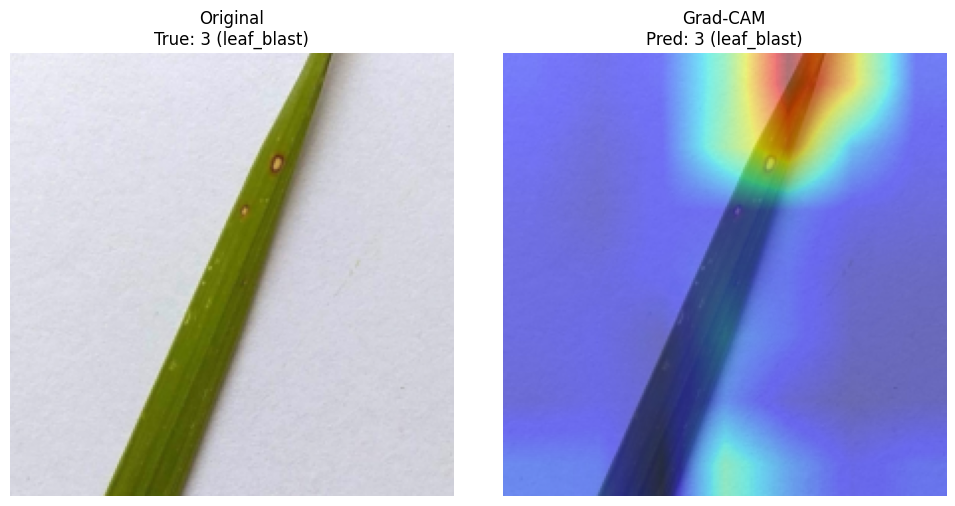

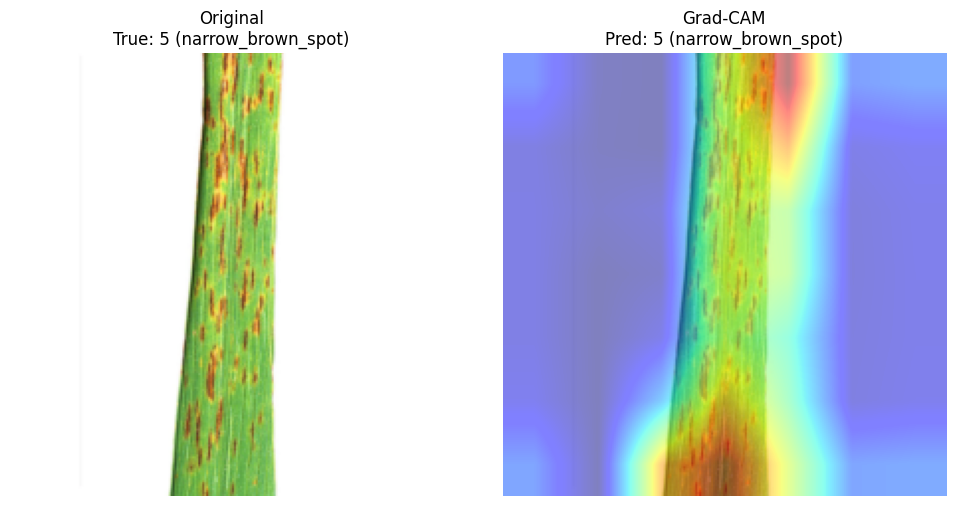

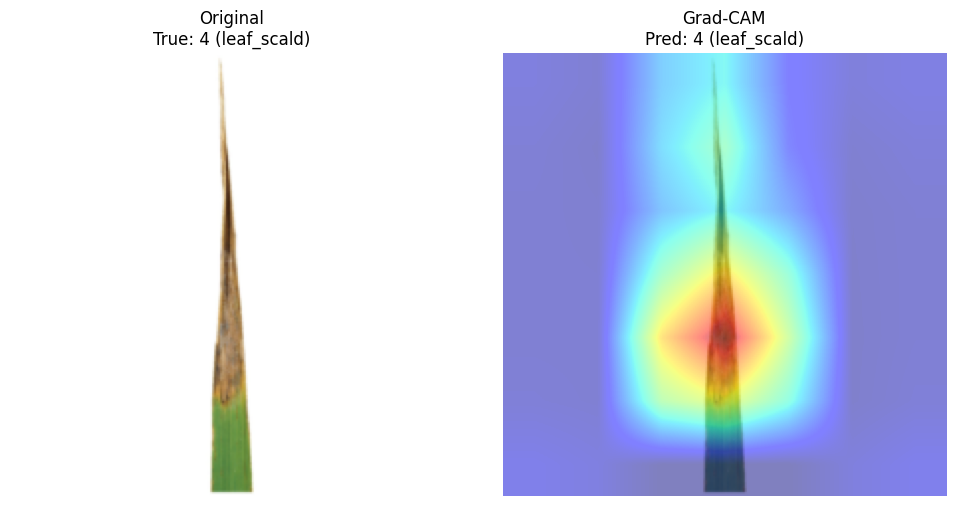

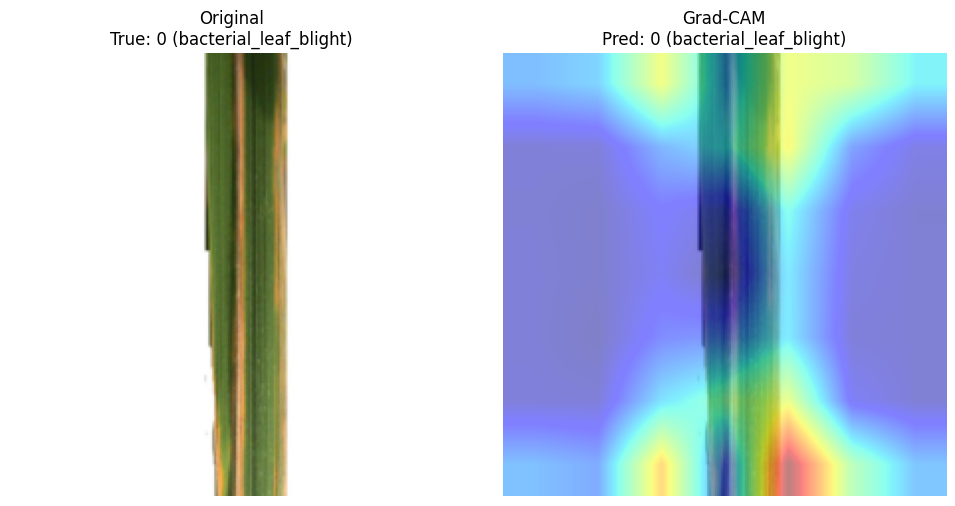

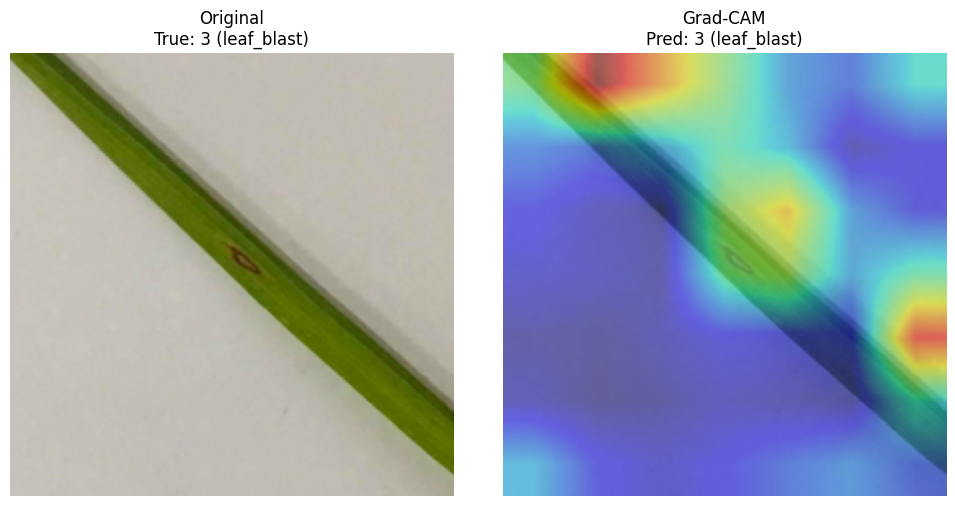

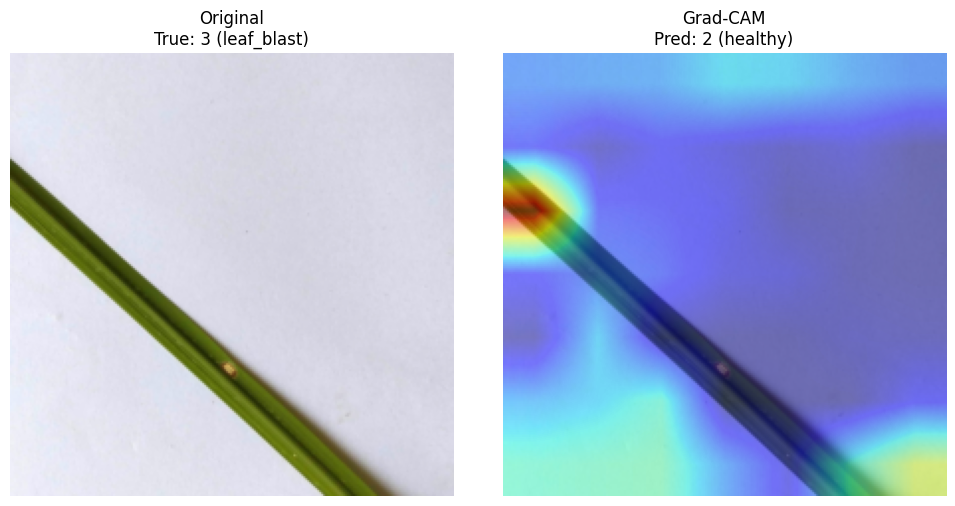

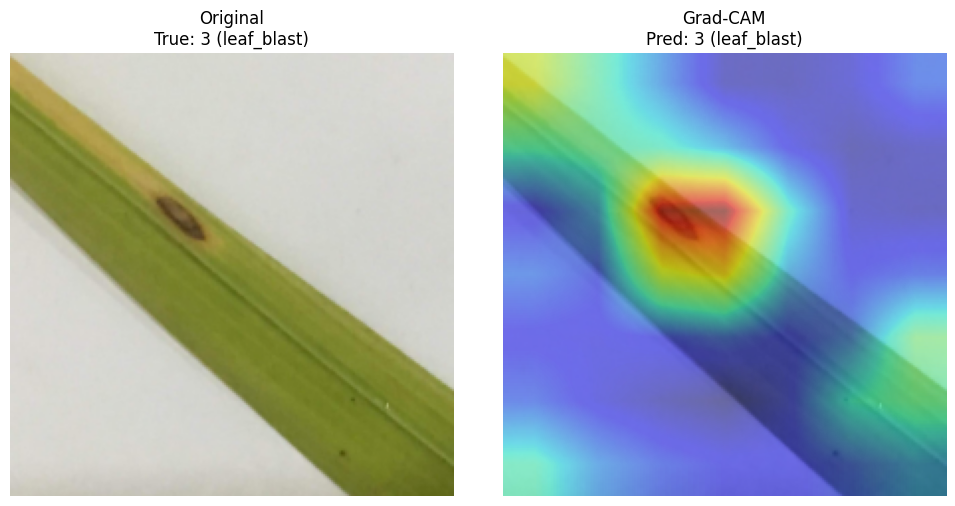

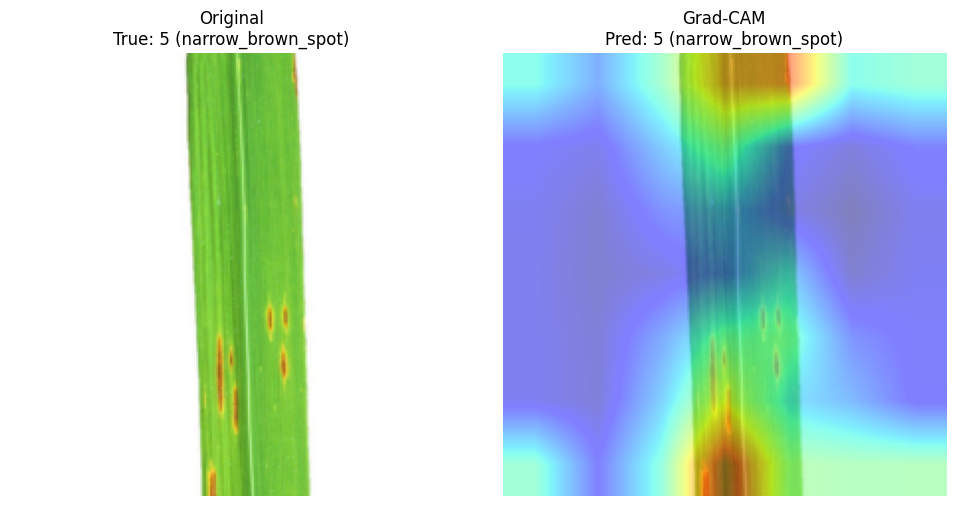

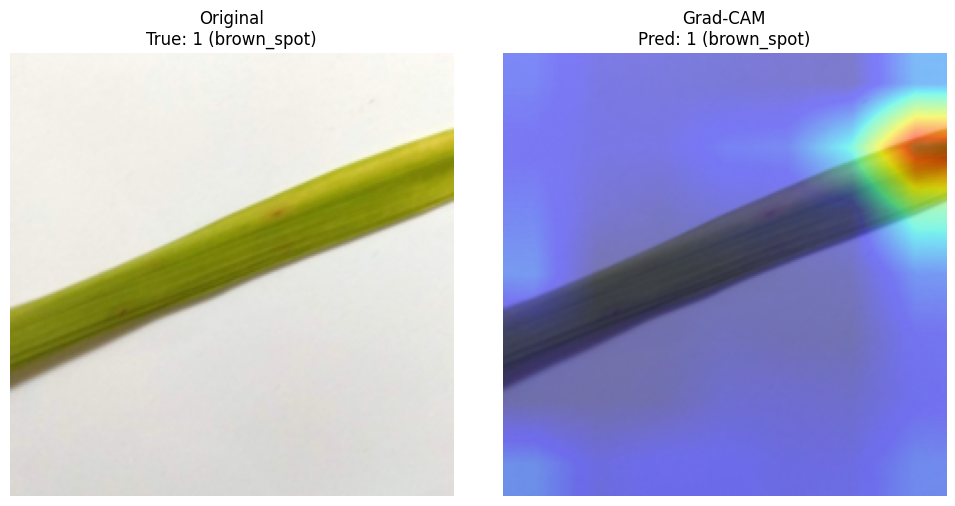

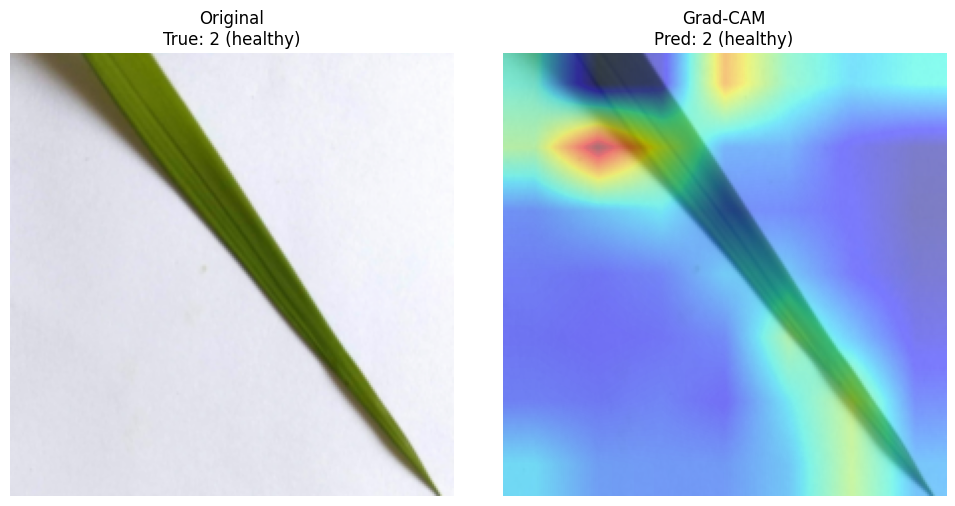

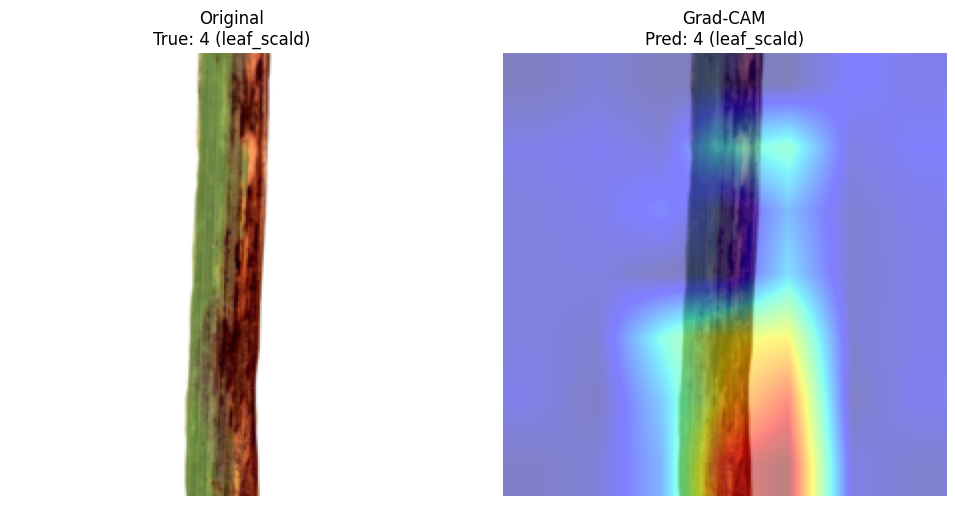

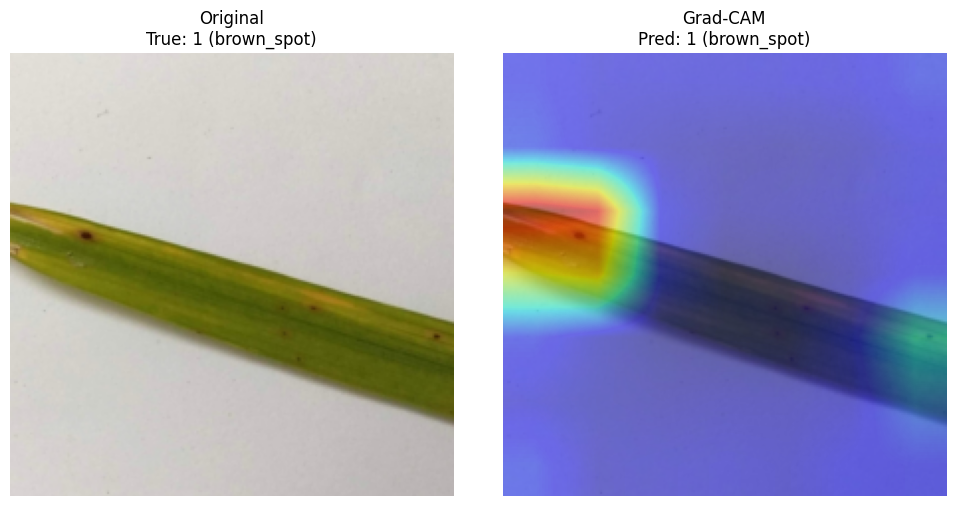

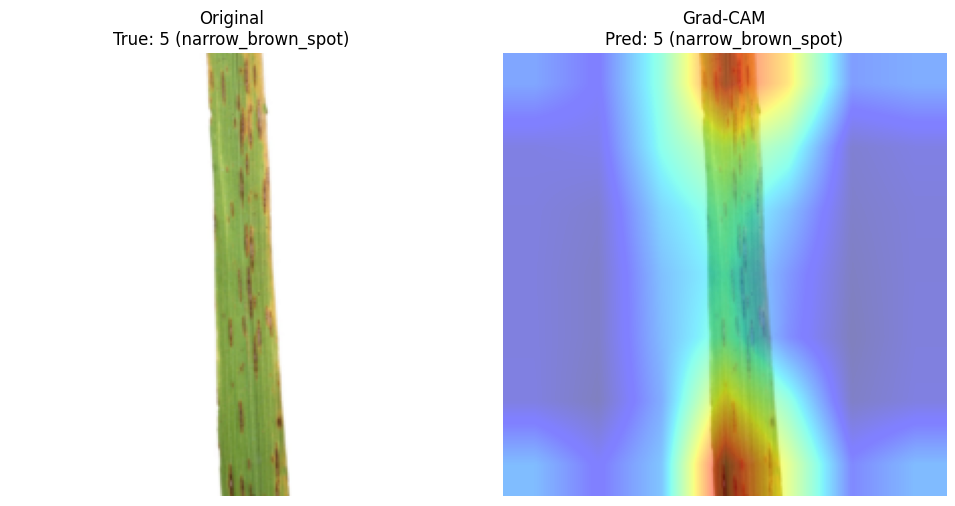

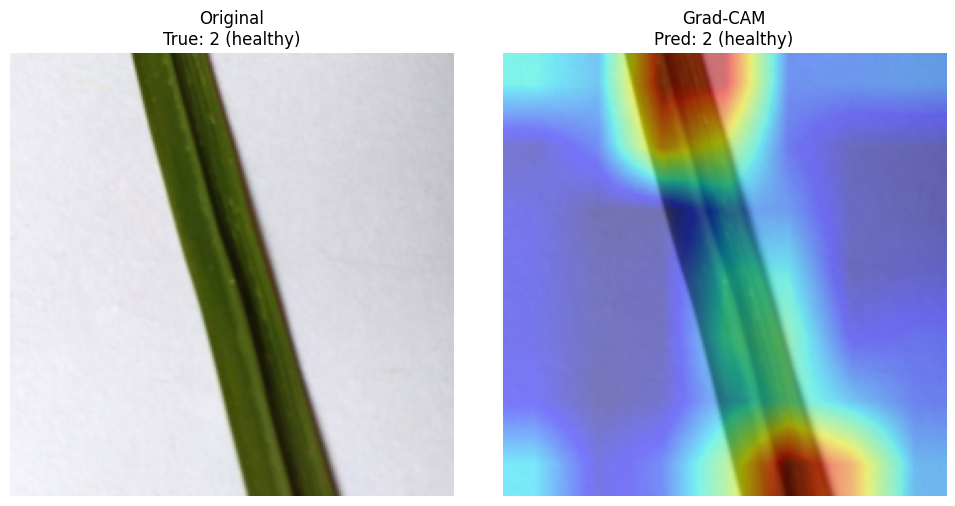

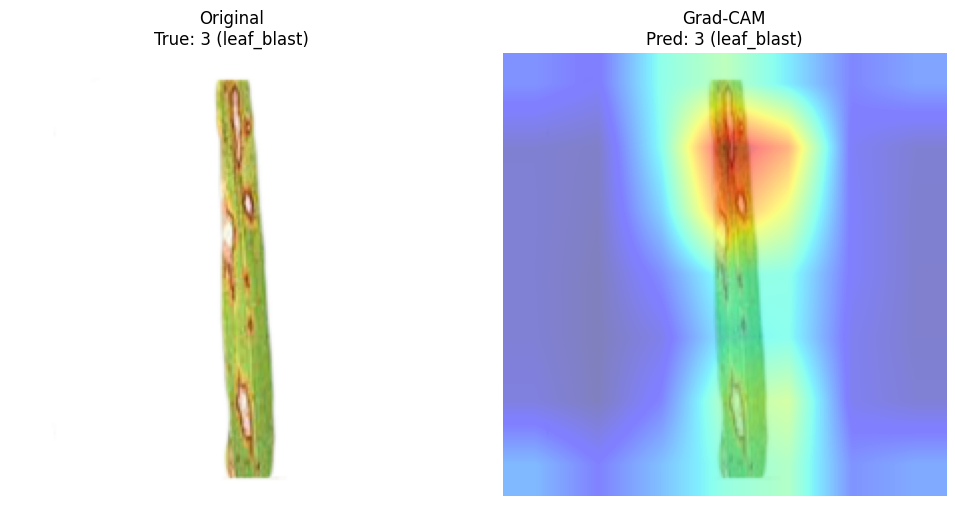

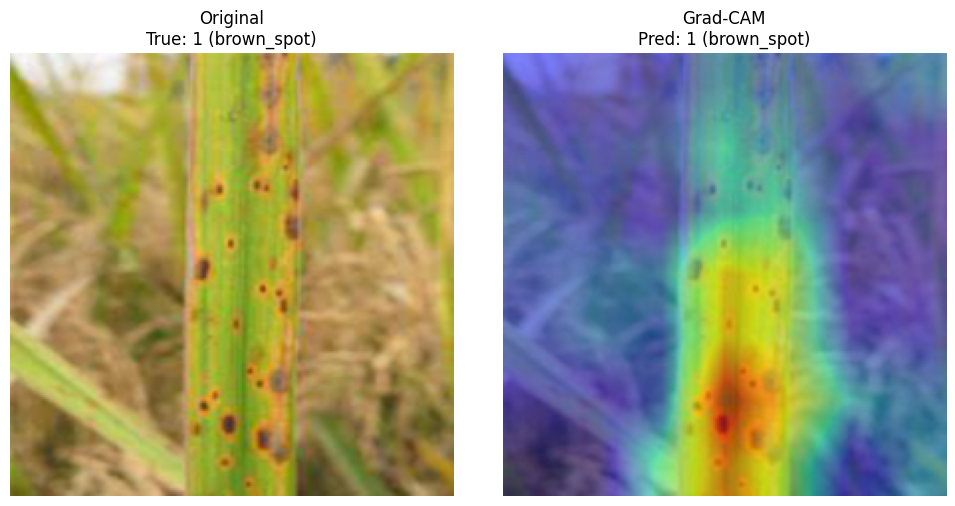

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# -------------------------
# Label mapping
# -------------------------
# Map class indices to class names (folder names)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# -------------------------
# Number of samples to visualize
# -------------------------
num_images = 20
random_indices = random.sample(range(len(val_dataset)), num_images)

# -------------------------
# Set model to evaluation mode
# -------------------------
model.eval()

# -------------------------
# Loop through selected validation images
# -------------------------
for idx in random_indices:
    img, true_label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Grad-CAM extraction
    activation_map = cam_extractor(pred_class, output)[0]  # shape: (1, H, W)
    cam = F.interpolate(activation_map.unsqueeze(0), size=img.shape[1:], mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # Convert image for display
    # original_img = to_pil_image(img)
    img_denorm = denormalize(img).clamp(0, 1)
    original_img = to_pil_image(img_denorm)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {true_label} ({idx_to_class[true_label]})")
    axes[0].axis("off")

    # Grad-CAM overlay
    axes[1].imshow(original_img)
    axes[1].imshow(cam, cmap='jet', alpha=0.5)
    axes[1].set_title(f"Grad-CAM\nPred: {pred_class} ({idx_to_class[pred_class]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


--- Fold 1 / 5 ---


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1: Loss=33.7245, Train Acc=0.7500
  Epoch 2: Loss=9.7730, Train Acc=0.9393
  Epoch 3: Loss=4.0457, Train Acc=0.9732
  Fold 1 Validation Accuracy: 0.9333


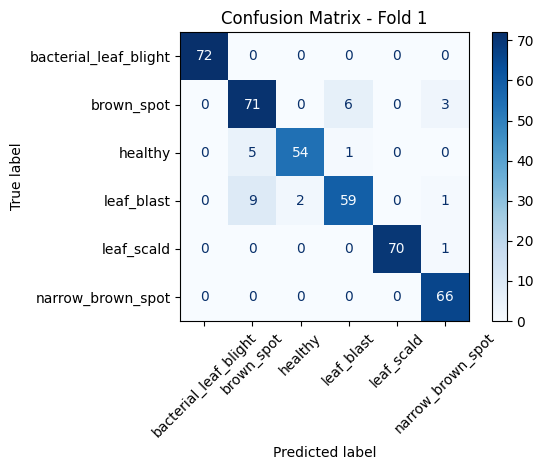


--- Fold 2 / 5 ---


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1: Loss=34.0937, Train Acc=0.7637
  Epoch 2: Loss=8.9217, Train Acc=0.9357
  Epoch 3: Loss=4.3229, Train Acc=0.9762
  Fold 2 Validation Accuracy: 0.9476


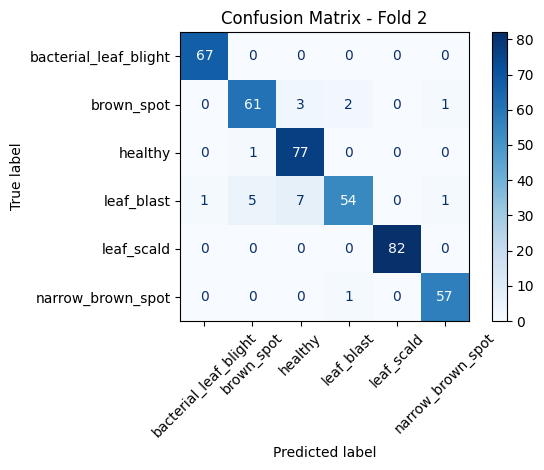


--- Fold 3 / 5 ---


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1: Loss=33.6386, Train Acc=0.7571
  Epoch 2: Loss=9.3151, Train Acc=0.9339
  Epoch 3: Loss=3.9632, Train Acc=0.9744
  Fold 3 Validation Accuracy: 0.9286


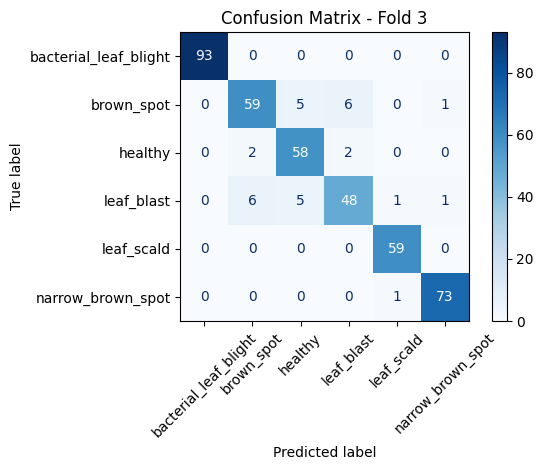


--- Fold 4 / 5 ---


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1: Loss=36.0300, Train Acc=0.7292
  Epoch 2: Loss=10.0527, Train Acc=0.9333
  Epoch 3: Loss=3.9004, Train Acc=0.9744
  Fold 4 Validation Accuracy: 0.9167


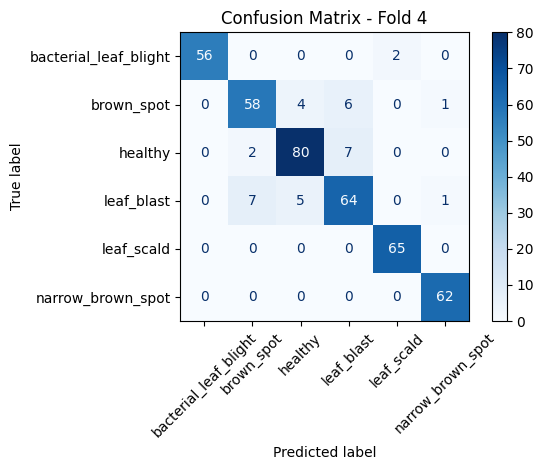


--- Fold 5 / 5 ---


C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uzmap\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1: Loss=34.5007, Train Acc=0.7536
  Epoch 2: Loss=9.3128, Train Acc=0.9327
  Epoch 3: Loss=4.6021, Train Acc=0.9702
  Fold 5 Validation Accuracy: 0.9167


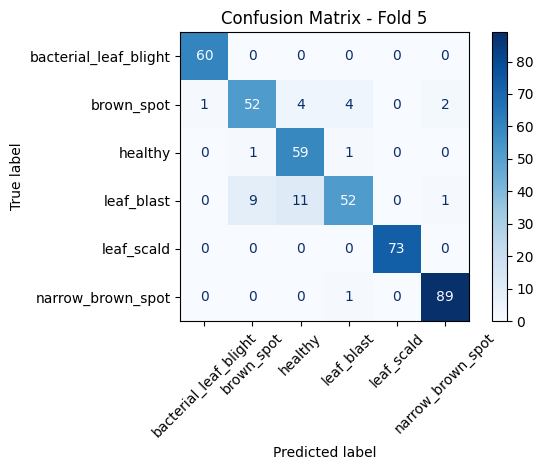


K-Fold Cross-Validation Results:
  Fold 1: 0.9333
  Fold 2: 0.9476
  Fold 3: 0.9286
  Fold 4: 0.9167
  Fold 5: 0.9167
  Average Accuracy: 0.9286


In [8]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Number of folds
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# For results
fold_results = []

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset.samples)):
    print(f"\n--- Fold {fold + 1} / {k_folds} ---")

    # Subset the dataset
    train_sub = Subset(train_dataset, train_idx)
    val_sub = Subset(train_dataset, val_idx)

    # Data loaders for this fold
    train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=32, shuffle=False)

    # Reset the model each fold
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)

    # Optimizer and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(3):  # reduce epochs for speed; increase if needed
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"  Epoch {epoch+1}: Loss={running_loss:.4f}, Train Acc={train_acc:.4f}")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    print(f"  Fold {fold + 1} Validation Accuracy: {val_acc:.4f}")
    fold_results.append(val_acc)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Final Results
# ----------------------------
print("\nK-Fold Cross-Validation Results:")
for i, acc in enumerate(fold_results):
    print(f"  Fold {i+1}: {acc:.4f}")
print(f"  Average Accuracy: {np.mean(fold_results):.4f}")
